In [7]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from lsc import LangevinSparseCoding

In [8]:
patch_size = 4
n_features = patch_size**2
n_latent = 2*patch_size
sparsity_penalty = 1.0
temperature = 1
dt = 0.1

In [14]:
def generate_bars_basis(patch_size:int=12):
    basis_images = np.zeros([2*patch_size,patch_size,patch_size])
    for i in range(patch_size):
        basis_images[i,i,:] = 1
        
    for i in range(patch_size):
        basis_images[i+patch_size,:,i] = 1
        
    return basis_images.reshape([2*patch_size,patch_size**2]).T

def plot_dictionary(dictionary, color=False, nrow=30, normalize=True,
                    scale_each=True, fig=None, ax=None, title="", size=8):
    """Plot all elements of dictionary in grid
    Parameters
    ----------
    dictionary : array-like, shape [n_features, n_basis]
        Dictionary
    color : bool, default=False
        Set True if dictionary 3 channel (color)
    nrow : int, default=30
        Number of dictionary elements in a row
    normalize : bool, default=True
        Normalize to [0,1] (see https://pytorch.org/vision/main/generated/torchvision.utils.make_grid.html)
    scale_each : bool, default=True
        Scale each element to [0,1] (see https://pytorch.org/vision/main/generated/torchvision.utils.make_grid.html)
    fig : matplotlib.pyplot figure handle, optional
        If not provided, new handle created and returned
    ax : matplotlib.pyplot axes handle, optional
        If not provided, new handle created and returned
    title : str, optional
        Title of plot
    size : float, default=8
        Plot size (inches)
    Returns
    -------
    fig : matplotlib.pyplot figure handle
    ax : matplotlib.pyplot axes handle
    """

    n_features, n_basis = dictionary.shape

    nch = 1
    if color:
        nch = 3

    patch_size = int(np.sqrt(n_features//nch))

    D_imgs = dictionary.T.reshape([n_basis, patch_size, patch_size, nch]).permute([
        0, 3, 1, 2])  # swap channel dims for torch
    grid_img = torchvision.utils.make_grid(
        D_imgs, nrow=nrow, normalize=normalize, scale_each=scale_each).cpu()

    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(size, size))

    ax.clear()
    ax.set_title(title)
    ax.imshow(grid_img.permute(1, 2, 0))  # swap channel dims for matplotlib
    ax.set_axis_off()
    fig.set_size_inches(size, size)
    fig.canvas.draw()
    return fig, ax

(<Figure size 800x800 with 1 Axes>, <Axes: >)

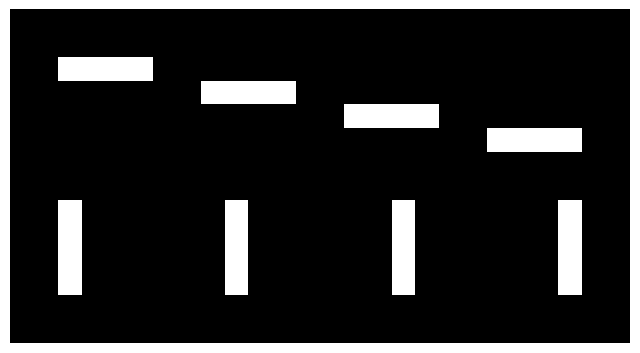

In [15]:
A = torch.FloatTensor(generate_bars_basis(patch_size=patch_size))
plot_dictionary(A,nrow=4)

Text(0.5, 1.0, 'generated image')

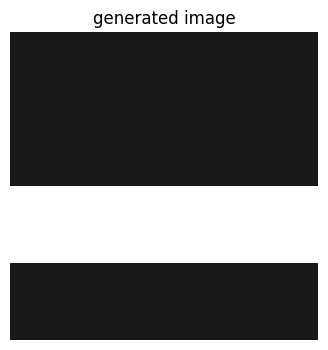

In [26]:
C = lambda s: s.abs().sum()
Cprime = lambda s: torch.sign(s)

lsc = LangevinSparseCoding(
    n_features=n_features,
    n_latent=n_latent,
    sparsity_penaly=sparsity_penalty,
    temperature=temperature,
    dt=dt,
    cost_function=C,
    cost_function_grad=Cprime
)

lsc.A = A
s_star = torch.zeros([n_latent,],dtype=torch.float)
s_star[2] = 1

NOISE_MEAN, NOISE_VARIANCE = 0 , 0.1
x = lsc.A@s_star + np.random.normal(NOISE_MEAN, NOISE_VARIANCE) # Additive Gaussian Noise

fig,ax = plt.subplots(figsize=(4,4))
ax.imshow(x.reshape(patch_size,patch_size),'gray',vmin=0,vmax=1)
ax.set_axis_off()
ax.set_title('generated image')

In [30]:
tmax = int(1e5)

s_inference = torch.ones_like(s_star) #Change to L0
# s_inference = th.zeros_like(s) #Change to L0
energies = []
S = []
S.append(s_inference.data.numpy().copy())
for n in tqdm(range(tmax)):

    energies.append(lsc.energy(x,s_inference).item())
    s_inference += torch.clone(lsc.first_order_langevin_update(x,s_inference))
    S.append(s_inference.data.numpy().copy())
S = np.asarray(S)
s_bar = S.mean(axis=0)
energies = np.asarray(energies)

lsc.set_temperature(0.) # set temperature to zero to get map estimate 
s_inference = torch.ones_like(s_star) #Change to L0
# s_inference = th.zeros_like(s) #Change to L0
energies = []
S = []
S.append(s_inference.data.numpy().copy())
for n in tqdm(range(tmax)):

    energies.append(lsc.energy(x,s_inference).item())
    s_inference += torch.clone(lsc.first_order_langevin_update(x,s_inference))
    S.append(s_inference.data.numpy().copy())
S = np.asarray(S)
s_map = S[-1,:]
energies = np.asarray(energies)

lsc.set_temperature(temperature)

100%|██████████| 100000/100000 [00:03<00:00, 27973.56it/s]


Text(0.5, 1.0, '${s}_{MAP}$ image')

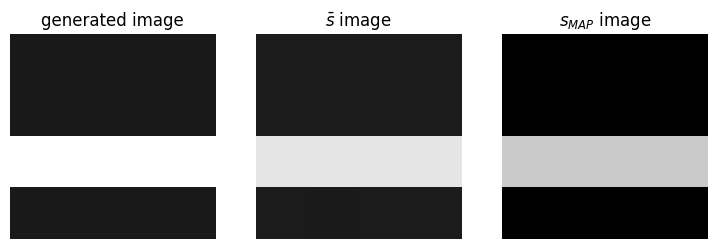

In [35]:
x_bar = lsc.A@s_bar
x_map = lsc.A@s_map

fig,axs = plt.subplots(1,3,figsize=(9,3))
ax = axs[0]
ax.imshow(x.reshape(patch_size,patch_size),'gray',vmin=0,vmax=1)
ax.set_axis_off()
ax.set_title('generated image')

ax = axs[1]
ax.imshow(x_bar.reshape(patch_size,patch_size),'gray',vmin=0,vmax=1)
ax.set_axis_off()
ax.set_title(r'$\bar{s}$ image')

ax = axs[2]
ax.imshow(x_map.reshape(patch_size,patch_size),'gray',vmin=0,vmax=1)
ax.set_axis_off()
ax.set_title(r'${s}_{MAP}$ image')